In [ ]:
#| hide
from model_evaluation.core import *

# model_testing

> A library to test fastai learners using some evaluation techniques.

This library will allow you to easily evaluate your `fastai` `Learner`s using different evaluation techinique such as `KFold` or `RepeatedKFold`.

## Install

To install the library, just run:

```sh
pip install model_testing
```

## How to use

This library provides a method that can help you in the process of model evaluation. Using the [scikit-learn validation techniques](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators) you can validate your deep learning models.

In order to validate your model, you will need to build and train various versions of it (for example, using a KFold validation, it is needed to build five different models).

For doing so, you need to provide: the `DataBlock` hparams (hyperparameters), the `DataLoader` hparams, the technique used to split the data, the `Learner` construction hparams, the learning mode (whether to use a pretrained model or not: `fit_one_cycle` or `finetune`) and the `Learner` training hparams. So, the first step is to define them all:

```python
db_hparams = {
    "blocks": (ImageBlock, MaskBlock(codes)),
    "get_items": partial(get_image_files, folders=['train']),
    "get_y": get_y_fn,
    "item_tfms": [Resize((480,640)), TargetMaskConvertTransform(), transformPipeline],
    "batch_tfms": Normalize.from_stats(*imagenet_stats)
}
dl_hparams = {
    "source": path_images,
    "bs": 4
}
technique = KFold(n_splits = 5)
learner_hparams = {
    "arch": resnet18,
    "pretrained": True,
    "metrics": [DiceMulti()]
}
learning_hparams = {
    "epochs": 10,
    "base_lr": 0.001,
    "freeze_epochs": 1
}
learning_mode = "finetune"
```

Then, you need to call the `evaluate` method with those defined hparams. After the execution, the method will return a dictionary of results (for each metric used to test the model, the value obtained in each fold).

```python
r = evaluate(
    db_hparams,
    dl_hparams,
    technique,
    learner_hparams,
    learning_hparams,
    learning_mode
)
```

Finally, you can plot the metrics using a boxplot from pandas, for example:

```python
import pandas as pd

df = pd.DataFrame(r)
df.boxplot("DiceMulti");

print(
    df["DiceMulti"].mean(),
    df["DiceMulti"].std()
)
```

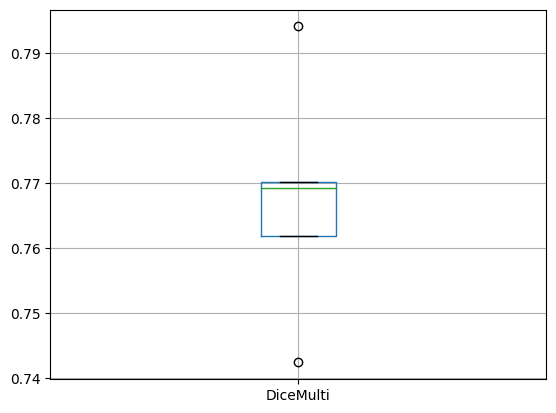

You can use this method to evaluate your model, but you can also use it to evaluate several models with distinct hparams: you can get the results for each of them and then plot the average of their metrics.